### 5장 차원 축소를 사용한 데이터 압축
- 5.1 주성분 분석을 통한 비지도 차원 축소
- 5.2 선형 판별 분석을 통한 지도 방식의 데이터 압축
- 5.3 커널 PCA를 사용하여 비선형 매핑
--- 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
## 함수 py파일 임포트 
import sys
sys.path.append('D:/YB_data/Git-Study/36.Python_Machine_Learning_3rd/my_func')
from plot_decision_regions import plot_decision_regions

In [3]:
## wine 데이터를 가져와 train/test 분리하고, 표준화 처리 
df_wine = pd.read_csv('data/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)

print(X_train_std.shape, X_test_std.shape, y_train.shape, y_test.shape)

(124, 13) (54, 13) (124,) (54,)


----
### 1. Sklearn's PCA 
----

- model accuracy = 0.9758064516129032


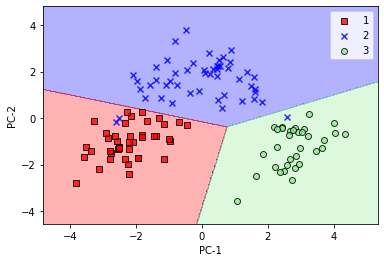

In [5]:
## 2차원으로 축소하여 logisticRegression 수행 
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
lr = LogisticRegression(random_state = 42)

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.fit_transform(X_test_std)

lr.fit(X_train_pca, y_train)
print('- model accuracy =', lr.score(X_train_pca, y_train))

plot_decision_regions(X_train_pca, y_train, classifier = lr)
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.legend()
plt.show()

In [11]:
## 참고. n_components = None 으로 지정하면, 차원축소를 하지 않고 분산의 크기순서대로 모든 주성분을 반환 
pca = PCA(n_components = None)
X_train_pca = pca.fit_transform(X_train_std)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[0.35730453 0.19209164 0.11006755 0.07250719 0.06973166 0.05341402
 0.04555029 0.0241568  0.02040417 0.01976974 0.01685307 0.01086639
 0.00728295]
0.9999999999999999


In [10]:
## 참고. n_components = 에 (0~1)사이 실수를 입력하면, 해당비율만큼 분산을 설명하기 위한 주성분 갯수를 자동으로 찾는다. 
pca = PCA(n_components=0.9)
pca.fit(X_train_std)
print('-주성분 개수 =', pca.n_components_)
print('-설명된 분산 비율 =', np.sum(pca.explained_variance_ratio_))

-주성분 개수 = 7
-설명된 분산 비율 = 0.9006668766038878


---
#### 2. LDA : Linear Discriminant Analysis (선형판별분석)
- PCA는 분산이 최대인 직교축을 찾는 반면, LDA는 최적구분을 위한 특성부분 공간을 찾는다. 
- PCA는 비지도, LDA는 지도학습 알고리즘임. LDA는 클래스 레이블별로 데이터를 나누어 평균을 구하는 방식으로  평균벡터를 만든다. 
---

- model accuracy = 1.0


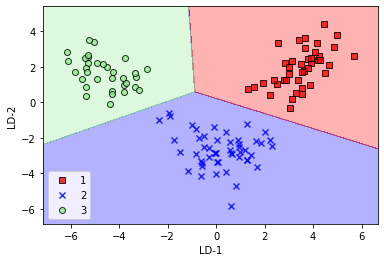

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components = 2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

lr = LogisticRegression(random_state = 42)
lr = lr.fit(X_train_lda, y_train)
print('- model accuracy =', lr.score(X_train_lda, y_train))

plot_decision_regions(X_train_lda, y_train, classifier = lr)
plt.xlabel('LD-1')
plt.ylabel('LD-2')
plt.legend()
plt.show()

- 2개의 차원만으로 완벽하게 구분 

----
#### 3. PCA의 커널화 버전(KPCA) 
- PCA, LDA는 비선형 문제에 적합하지 않다. --> 커널 PCA를 사용, 데이터를 선형분류에 적합한 새로운 저차원 부분공간으로 변환
----

In [22]:
## 실습을 위한 비선형 데이터셋 만들기 
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

print(X[:5])
print(y[:5])

[[ 0.8713187   0.49071755]
 [ 0.71547241 -0.45866785]
 [ 1.46253829 -0.38659931]
 [-0.22252093  0.97492791]
 [ 0.32769911 -0.240278  ]]
[0 1 1 0 1]


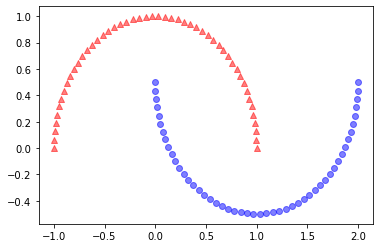

In [23]:
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)
plt.show()

In [25]:
## 비선형 데이터에 대한 차원축소 : kernel = 'rbf'
from sklearn.decomposition import KernelPCA
X, y = make_moons(n_samples = 100, random_state = 42) 

scikit_kpca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 15)
X_sklearnpca = scikit_kpca.fit_transform(X)

print(X_sklearnpca[:5])
print(y[:5])

[[ 0.3232991   0.29841965]
 [ 0.09932993 -0.20228953]
 [ 0.35038479 -0.18363537]
 [-0.13245717  0.2402938 ]
 [-0.1525819   0.26997043]]
[1 1 1 0 0]


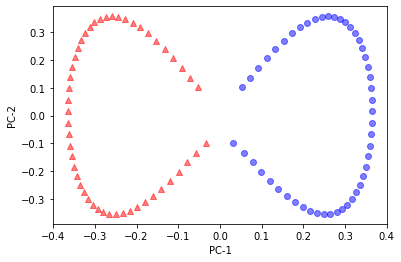

In [26]:
plt.scatter(X_sklearnpca[y == 0, 0], X_sklearnpca[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X_sklearnpca[y == 1, 0], X_sklearnpca[y == 1, 1], color='blue', marker='o', alpha=0.5)
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.show()